In [1]:
###############################################################################
# The Institute for the Design of Advanced Energy Systems Integrated Platform
# Framework (IDAES IP) was produced under the DOE Institute for the
# Design of Advanced Energy Systems (IDAES).
#
# Copyright (c) 2018-2023 by the software owners: The Regents of the
# University of California, through Lawrence Berkeley National Laboratory,
# National Technology & Engineering Solutions of Sandia, LLC, Carnegie Mellon
# University, West Virginia University Research Corporation, et al.
# All rights reserved.  Please see the files COPYRIGHT.md and LICENSE.md
# for full copyright and license information.
###############################################################################

# PETSc Time-stepping Solver -- PID Control and Steam Example
Author: John Eslick  
Maintainer: John Eslick  
Updated: 2023-06-01

This example provides an overview of the PETSc time-stepping solver utilities in IDAES, which can be used to solve systems of differential algebraic equations (DAEs). PETSc is a solver suite developed primarily by Argonne National Lab (https://petsc.org/release/). IDAES provides a wrapper for PETSc (https://github.com/IDAES/idaes-ext/tree/main/petsc) that uses the AMPL solver interface (https://ampl.com/resources/learn-more/hooking-your-solver-to-ampl/) and utility functions that allow Pyomo and Pyomo.DAE (https://pyomo.readthedocs.io/en/stable/modeling_extensions/dae.html) problems to be solved using PETSc.

This demonstration uses the IDAES PID controller model and a flowsheet arranged like so:

```
             
->--|><|------[]------|><|-->-
   valve_1   tank   valve_2   
```

where the tank pressure is controlled by the opening of valve_1.

## Prerequisites

The PETSc solver is an extra download for IDAES, which can be downloaded using the command ```idaes get-extensions --extra petsc```, if it is not installed already. See the IDAES solver documentation for more information (https://idaes-pse.readthedocs.io/en/stable/reference_guides/core/solvers.html).

You may want to review the ["PETSc Time-stepping Solver -- Chemical Akzo Nobel Example"](petsc_chem_example_doc.md) notebook first.

## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import pyomo.environ as pyo
import pyomo.dae as pyodae
import idaes.core.solvers.petsc as petsc  # petsc utilities module
import idaes_examples.mod.dae.petsc.pid_steam_tank as pid
from idaes.core.util.math import smooth_max, smooth_min

## Model Set Up

In [3]:
# to see the model code uncomment the line below
# ??pid

In [4]:
m = pid.create_model(
    time_set=[0, 12],
    nfe=1,
    calc_integ=True,
)

2023-11-02 10:31:29 [INFO] idaes.init.fs.valve_1: Initialization Complete: optimal - Optimal Solution Found


2023-11-02 10:31:29 [INFO] idaes.init.fs.tank.control_volume: Initialization Complete


2023-11-02 10:31:29 [INFO] idaes.init.fs.tank: Initialization Complete: optimal - Optimal Solution Found


2023-11-02 10:31:29 [INFO] idaes.init.fs.valve_2: Initialization Complete: optimal - Optimal Solution Found


## Solve

In [5]:
result = petsc.petsc_dae_by_time_element(
    m,
    time=m.fs.time,
    ts_options={
        "--ts_type": "beuler",
        "--ts_dt": 0.1,
        "--ts_monitor": "",  # set initial step to 0.1
        "--ts_save_trajectory": 1,
    },
)
tj = result.trajectory  # trajectroy data
res = result.results  # solver status list

2023-11-02 10:31:30 [INFO] idaes.solve.petsc-dae: Called fg_read, err: 0 (0 is good)


2023-11-02 10:31:30 [INFO] idaes.solve.petsc-dae: ---------------------------------------------------


2023-11-02 10:31:30 [INFO] idaes.solve.petsc-dae: DAE: 0


2023-11-02 10:31:30 [INFO] idaes.solve.petsc-dae: Reading nl file: C:\Users\dkgun\AppData\Local\Temp\tmp8y_z4ws2.pyomo.nl


2023-11-02 10:31:30 [INFO] idaes.solve.petsc-dae: Number of constraints: 28


2023-11-02 10:31:30 [INFO] idaes.solve.petsc-dae: Number of nonlinear constraints: 14


2023-11-02 10:31:30 [INFO] idaes.solve.petsc-dae: Number of linear constraints: 14


2023-11-02 10:31:30 [INFO] idaes.solve.petsc-dae: Number of inequalities: 0


2023-11-02 10:31:30 [INFO] idaes.solve.petsc-dae: Number of variables: 28


2023-11-02 10:31:30 [INFO] idaes.solve.petsc-dae: Number of integers: 0


2023-11-02 10:31:30 [INFO] idaes.solve.petsc-dae: Number of binary: 0


2023-11-02 10:31:30 [INFO] idaes.solve.petsc-dae: Number of objectives: 0 (Ignoring)


2023-11-02 10:31:30 [INFO] idaes.solve.petsc-dae: Number of non-zeros in Jacobian: 83 


2023-11-02 10:31:30 [INFO] idaes.solve.petsc-dae: Number of degrees of freedom: 0


2023-11-02 10:31:30 [INFO] idaes.solve.petsc-dae: ---------------------------------------------------


2023-11-02 10:31:30 [INFO] idaes.solve.petsc-dae:   0 SNES Function norm 5.783088779321e+05 


2023-11-02 10:31:30 [INFO] idaes.solve.petsc-dae:   1 SNES Function norm 4.315325974705e+05 


2023-11-02 10:31:30 [INFO] idaes.solve.petsc-dae:   2 SNES Function norm 7.639793381288e+04 


2023-11-02 10:31:30 [INFO] idaes.solve.petsc-dae:   3 SNES Function norm 5.928557930246e+03 


2023-11-02 10:31:30 [INFO] idaes.solve.petsc-dae:   4 SNES Function norm 5.008361736228e+01 


2023-11-02 10:31:30 [INFO] idaes.solve.petsc-dae:   5 SNES Function norm 3.698195211732e-03 


2023-11-02 10:31:30 [INFO] idaes.solve.petsc-dae:   6 SNES Function norm 3.725294295263e-09 


2023-11-02 10:31:30 [INFO] idaes.solve.petsc-dae: SNESConvergedReason = SNES_CONVERGED_FNORM_RELATIVE, in 6 iterations


2023-11-02 10:31:30 [INFO] idaes.solve.petsc-dae: SNES_CONVERGED_FNORM_RELATIVE


2023-11-02 10:31:30 [INFO] idaes.solve.petsc-dae: Called fg_read, err: 0 (0 is good)


2023-11-02 10:31:30 [INFO] idaes.solve.petsc-dae: ---------------------------------------------------


2023-11-02 10:31:30 [INFO] idaes.solve.petsc-dae: DAE: 1


2023-11-02 10:31:30 [INFO] idaes.solve.petsc-dae: Reading nl file: C:\Users\dkgun\AppData\Local\Temp\tmp3aw8uqg4.pyomo.nl


2023-11-02 10:31:30 [INFO] idaes.solve.petsc-dae: Number of constraints: 29


2023-11-02 10:31:30 [INFO] idaes.solve.petsc-dae: Number of nonlinear constraints: 15


2023-11-02 10:31:30 [INFO] idaes.solve.petsc-dae: Number of linear constraints: 14


2023-11-02 10:31:30 [INFO] idaes.solve.petsc-dae: Number of inequalities: 0


2023-11-02 10:31:30 [INFO] idaes.solve.petsc-dae: Number of variables: 34


2023-11-02 10:31:30 [INFO] idaes.solve.petsc-dae: Number of integers: 0


2023-11-02 10:31:30 [INFO] idaes.solve.petsc-dae: Number of binary: 0


2023-11-02 10:31:30 [INFO] idaes.solve.petsc-dae: Number of objectives: 0 (Ignoring)


2023-11-02 10:31:30 [INFO] idaes.solve.petsc-dae: Number of non-zeros in Jacobian: 91 


2023-11-02 10:31:30 [INFO] idaes.solve.petsc-dae: Explicit time variable: 0


2023-11-02 10:31:30 [INFO] idaes.solve.petsc-dae: Number of derivatives: 5


2023-11-02 10:31:30 [INFO] idaes.solve.petsc-dae: Number of differential vars: 5


2023-11-02 10:31:30 [INFO] idaes.solve.petsc-dae: Number of algebraic vars: 24


2023-11-02 10:31:30 [INFO] idaes.solve.petsc-dae: Number of state vars: 29


2023-11-02 10:31:30 [INFO] idaes.solve.petsc-dae: Number of degrees of freedom: 0


2023-11-02 10:31:30 [INFO] idaes.solve.petsc-dae: ---------------------------------------------------


2023-11-02 10:31:30 [INFO] idaes.solve.petsc-dae: 0 TS dt 0.1 time 0.


2023-11-02 10:31:33 [INFO] idaes.solve.petsc-dae: 1 TS dt 0.025 time 0.025


2023-11-02 10:31:33 [INFO] idaes.solve.petsc-dae: 2 TS dt 0.0154252 time 0.0381739


2023-11-02 10:31:33 [INFO] idaes.solve.petsc-dae: 3 TS dt 0.0133373 time 0.0510085


2023-11-02 10:31:33 [INFO] idaes.solve.petsc-dae: 4 TS dt 0.0136013 time 0.0643458


2023-11-02 10:31:33 [INFO] idaes.solve.petsc-dae: 5 TS dt 0.0141735 time 0.0779471


2023-11-02 10:31:33 [INFO] idaes.solve.petsc-dae: 6 TS dt 0.0146392 time 0.0921205


2023-11-02 10:31:33 [INFO] idaes.solve.petsc-dae: 7 TS dt 0.0152517 time 0.10676


2023-11-02 10:31:33 [INFO] idaes.solve.petsc-dae: 8 TS dt 0.0158389 time 0.122011


2023-11-02 10:31:33 [INFO] idaes.solve.petsc-dae: 9 TS dt 0.0165162 time 0.13785


2023-11-02 10:31:33 [INFO] idaes.solve.petsc-dae: 10 TS dt 0.0172093 time 0.154367


2023-11-02 10:31:33 [INFO] idaes.solve.petsc-dae: 11 TS dt 0.0179712 time 0.171576


2023-11-02 10:31:33 [INFO] idaes.solve.petsc-dae: 12 TS dt 0.0187679 time 0.189547


2023-11-02 10:31:33 [INFO] idaes.solve.petsc-dae: 13 TS dt 0.0196222 time 0.208315


2023-11-02 10:31:33 [INFO] idaes.solve.petsc-dae: 14 TS dt 0.020514 time 0.227937


2023-11-02 10:31:33 [INFO] idaes.solve.petsc-dae: 15 TS dt 0.0214472 time 0.248451


2023-11-02 10:31:33 [INFO] idaes.solve.petsc-dae: 16 TS dt 0.022401 time 0.269898


2023-11-02 10:31:33 [INFO] idaes.solve.petsc-dae: 17 TS dt 0.0233619 time 0.292299


2023-11-02 10:31:33 [INFO] idaes.solve.petsc-dae: 18 TS dt 0.0243005 time 0.315661


2023-11-02 10:31:33 [INFO] idaes.solve.petsc-dae: 19 TS dt 0.0251894 time 0.339962


2023-11-02 10:31:33 [INFO] idaes.solve.petsc-dae: 20 TS dt 0.0259944 time 0.365151


2023-11-02 10:31:33 [INFO] idaes.solve.petsc-dae: 21 TS dt 0.0266898 time 0.391146


2023-11-02 10:31:33 [INFO] idaes.solve.petsc-dae: 22 TS dt 0.0272563 time 0.417835


2023-11-02 10:31:33 [INFO] idaes.solve.petsc-dae: 23 TS dt 0.0276902 time 0.445092


2023-11-02 10:31:34 [INFO] idaes.solve.petsc-dae: 24 TS dt 0.0279997 time 0.472782


2023-11-02 10:31:34 [INFO] idaes.solve.petsc-dae: 25 TS dt 0.0282038 time 0.500782


2023-11-02 10:31:34 [INFO] idaes.solve.petsc-dae: 26 TS dt 0.028326 time 0.528985


2023-11-02 10:31:34 [INFO] idaes.solve.petsc-dae: 27 TS dt 0.0283913 time 0.557311


2023-11-02 10:31:34 [INFO] idaes.solve.petsc-dae: 28 TS dt 0.0284218 time 0.585703


2023-11-02 10:31:34 [INFO] idaes.solve.petsc-dae: 29 TS dt 0.0284362 time 0.614124


2023-11-02 10:31:34 [INFO] idaes.solve.petsc-dae: 30 TS dt 0.0284488 time 0.642561


2023-11-02 10:31:34 [INFO] idaes.solve.petsc-dae: 31 TS dt 0.0284703 time 0.671009


2023-11-02 10:31:34 [INFO] idaes.solve.petsc-dae: 32 TS dt 0.0285087 time 0.69948


2023-11-02 10:31:34 [INFO] idaes.solve.petsc-dae: 33 TS dt 0.0285693 time 0.727988


2023-11-02 10:31:34 [INFO] idaes.solve.petsc-dae: 34 TS dt 0.0286562 time 0.756558


2023-11-02 10:31:34 [INFO] idaes.solve.petsc-dae: 35 TS dt 0.0287722 time 0.785214


2023-11-02 10:31:34 [INFO] idaes.solve.petsc-dae: 36 TS dt 0.0289195 time 0.813986


2023-11-02 10:31:34 [INFO] idaes.solve.petsc-dae: 37 TS dt 0.0291001 time 0.842906


2023-11-02 10:31:34 [INFO] idaes.solve.petsc-dae: 38 TS dt 0.0293154 time 0.872006


2023-11-02 10:31:34 [INFO] idaes.solve.petsc-dae: 39 TS dt 0.0295672 time 0.901321


2023-11-02 10:31:34 [INFO] idaes.solve.petsc-dae: 40 TS dt 0.0298571 time 0.930888


2023-11-02 10:31:34 [INFO] idaes.solve.petsc-dae: 41 TS dt 0.0301872 time 0.960745


2023-11-02 10:31:34 [INFO] idaes.solve.petsc-dae: 42 TS dt 0.0305596 time 0.990933


2023-11-02 10:31:34 [INFO] idaes.solve.petsc-dae: 43 TS dt 0.0309769 time 1.02149


2023-11-02 10:31:34 [INFO] idaes.solve.petsc-dae: 44 TS dt 0.031442 time 1.05247


2023-11-02 10:31:34 [INFO] idaes.solve.petsc-dae: 45 TS dt 0.0319585 time 1.08391


2023-11-02 10:31:34 [INFO] idaes.solve.petsc-dae: 46 TS dt 0.0325305 time 1.11587


2023-11-02 10:31:34 [INFO] idaes.solve.petsc-dae: 47 TS dt 0.0331626 time 1.1484


2023-11-02 10:31:34 [INFO] idaes.solve.petsc-dae: 48 TS dt 0.0338606 time 1.18156


2023-11-02 10:31:34 [INFO] idaes.solve.petsc-dae: 49 TS dt 0.0346311 time 1.21542


2023-11-02 10:31:34 [INFO] idaes.solve.petsc-dae: 50 TS dt 0.0354817 time 1.25005


2023-11-02 10:31:34 [INFO] idaes.solve.petsc-dae: 51 TS dt 0.0364218 time 1.28554


2023-11-02 10:31:34 [INFO] idaes.solve.petsc-dae: 52 TS dt 0.0374622 time 1.32196


2023-11-02 10:31:34 [INFO] idaes.solve.petsc-dae: 53 TS dt 0.0386159 time 1.35942


2023-11-02 10:31:34 [INFO] idaes.solve.petsc-dae: 54 TS dt 0.0398987 time 1.39804


2023-11-02 10:31:34 [INFO] idaes.solve.petsc-dae: 55 TS dt 0.0413295 time 1.43793


2023-11-02 10:31:34 [INFO] idaes.solve.petsc-dae: 56 TS dt 0.0429313 time 1.47926


2023-11-02 10:31:35 [INFO] idaes.solve.petsc-dae: 57 TS dt 0.0447325 time 1.5222


2023-11-02 10:31:35 [INFO] idaes.solve.petsc-dae: 58 TS dt 0.0467682 time 1.56693


2023-11-02 10:31:35 [INFO] idaes.solve.petsc-dae: 59 TS dt 0.0490823 time 1.6137


2023-11-02 10:31:35 [INFO] idaes.solve.petsc-dae: 60 TS dt 0.0517305 time 1.66278


2023-11-02 10:31:35 [INFO] idaes.solve.petsc-dae: 61 TS dt 0.0547839 time 1.71451


2023-11-02 10:31:35 [INFO] idaes.solve.petsc-dae: 62 TS dt 0.0583343 time 1.76929


2023-11-02 10:31:35 [INFO] idaes.solve.petsc-dae: 63 TS dt 0.0625012 time 1.82763


2023-11-02 10:31:35 [INFO] idaes.solve.petsc-dae: 64 TS dt 0.0674415 time 1.89013


2023-11-02 10:31:35 [INFO] idaes.solve.petsc-dae: 65 TS dt 0.0733598 time 1.95757


2023-11-02 10:31:35 [INFO] idaes.solve.petsc-dae: 66 TS dt 0.0805186 time 2.03093


2023-11-02 10:31:35 [INFO] idaes.solve.petsc-dae: 67 TS dt 0.0892348 time 2.11145


2023-11-02 10:31:35 [INFO] idaes.solve.petsc-dae: 68 TS dt 0.0998324 time 2.20068


2023-11-02 10:31:35 [INFO] idaes.solve.petsc-dae: 69 TS dt 0.112487 time 2.30052


2023-11-02 10:31:35 [INFO] idaes.solve.petsc-dae: 70 TS dt 0.12691 time 2.413


2023-11-02 10:31:35 [INFO] idaes.solve.petsc-dae: 71 TS dt 0.142117 time 2.53991


2023-11-02 10:31:35 [INFO] idaes.solve.petsc-dae: 72 TS dt 0.157007 time 2.68203


2023-11-02 10:31:35 [INFO] idaes.solve.petsc-dae: 73 TS dt 0.171623 time 2.83904


2023-11-02 10:31:35 [INFO] idaes.solve.petsc-dae: 74 TS dt 0.187368 time 3.01066


2023-11-02 10:31:35 [INFO] idaes.solve.petsc-dae: 75 TS dt 0.206382 time 3.19803


2023-11-02 10:31:35 [INFO] idaes.solve.petsc-dae: 76 TS dt 0.231364 time 3.40441


2023-11-02 10:31:35 [INFO] idaes.solve.petsc-dae: 77 TS dt 0.266076 time 3.63577


2023-11-02 10:31:35 [INFO] idaes.solve.petsc-dae: 78 TS dt 0.316702 time 3.90185


2023-11-02 10:31:35 [INFO] idaes.solve.petsc-dae: 79 TS dt 0.394852 time 4.21855


2023-11-02 10:31:35 [INFO] idaes.solve.petsc-dae: 80 TS dt 0.525171 time 4.6134


2023-11-02 10:31:35 [INFO] idaes.solve.petsc-dae: 81 TS dt 0.767756 time 5.13857


2023-11-02 10:31:35 [INFO] idaes.solve.petsc-dae: 82 TS dt 1.29836 time 5.90633


2023-11-02 10:31:35 [INFO] idaes.solve.petsc-dae: 83 TS dt 2.39766 time 7.20469


2023-11-02 10:31:35 [INFO] idaes.solve.petsc-dae: 84 TS dt 2.39766 time 9.60234


2023-11-02 10:31:35 [INFO] idaes.solve.petsc-dae: 85 TS dt 23.9766 time 12.


2023-11-02 10:31:35 [INFO] idaes.solve.petsc-dae: TSConvergedReason = TS_CONVERGED_TIME


2023-11-02 10:31:35 [INFO] idaes.solve.petsc-dae: TS_CONVERGED_TIME


## Plot Trajectory

At the initial conditions the valve is fully open.  At t=0, the controller is activated and the controller adjusts the opening of valve 1 to keep the tank pressure at the setpoint of 300 kPa.

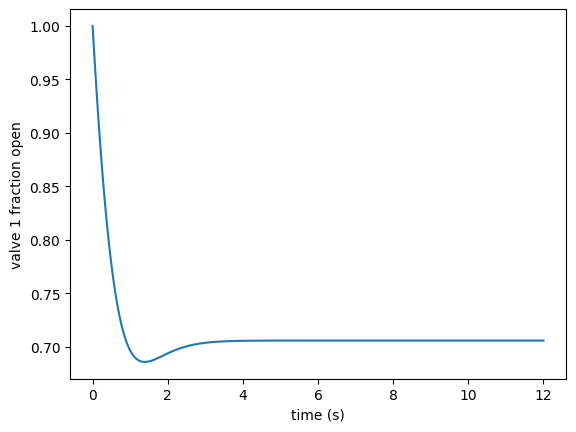

In [6]:
a = plt.plot(tj.time, tj.get_vec(m.fs.valve_1.valve_opening[12]))
a = plt.ylabel("valve 1 fraction open")
a = plt.xlabel("time (s)")

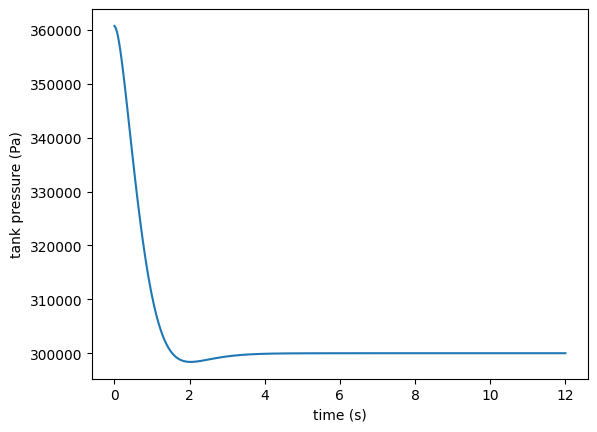

In [7]:
a = plt.plot(tj.time, tj.get_vec(m.fs.tank.control_volume.properties_out[12].pressure))
a = plt.ylabel("tank pressure (Pa)")
a = plt.xlabel("time (s)")

## Model a ramp in inlet pressure

Next we show how to add an explicit time variable and ramp the inlet pressure from 500 kPa to 600 kPa between 10 and 12 seconds.

In [8]:
# Create a new copy of the model that runs to 24 seconds, and add a constraint.

m = pid.create_model(
    time_set=[0, 24],
    nfe=1,
    calc_integ=True,
)
# time_var will be an explicit time variable we can use in constraints.
m.fs.time_var = pyo.Var(m.fs.time)

# We'll add a constraint to calculate the inlet pressure based on time,
# so we need to unfix pressure.
m.fs.valve_1.control_volume.properties_in[0].pressure.unfix()
m.fs.valve_1.control_volume.properties_in[24].pressure.unfix()

# The solver will directly set the time variable for the DAE solve, but
# solving the initial conditions is just a system of nonlinear equations,
# so we need to fix the initial time.
m.fs.time_var[0].fix(m.fs.time.first())

# We could break up the time domain and solve this in pieces, but creative use
# of min and max will let us create the ramping function we want.
# From 10s to 12s ramp inlet pressure from 500,000 Pa to 600,000 Pa
@m.fs.Constraint(m.fs.time)
def inlet_pressure_eqn(b, t):
    return b.valve_1.control_volume.properties_in[t].pressure == smooth_min(
        600000, smooth_max(500000, 50000 * (b.time_var[t] - 10) + 500000)
    )

2023-11-02 10:31:37 [INFO] idaes.init.fs.valve_1: Initialization Complete: optimal - Optimal Solution Found


2023-11-02 10:31:37 [INFO] idaes.init.fs.tank.control_volume: Initialization Complete


2023-11-02 10:31:37 [INFO] idaes.init.fs.tank: Initialization Complete: optimal - Optimal Solution Found


2023-11-02 10:31:37 [INFO] idaes.init.fs.valve_2: Initialization Complete: optimal - Optimal Solution Found


In [9]:
# Solve the new problem.  Notice the new argument specifying the explicit time variable.
result = petsc.petsc_dae_by_time_element(
    m,
    time=m.fs.time,
    timevar=m.fs.time_var,
    ts_options={
        "--ts_type": "beuler",
        "--ts_dt": 0.1,
        "--ts_monitor": "",  # set initial step to 0.1
        "--ts_save_trajectory": 1,
    },
)
tj = result.trajectory  # trajectroy data
res = result.results  # solver status list

2023-11-02 10:31:37 [INFO] idaes.solve.petsc-dae: Called fg_read, err: 0 (0 is good)


2023-11-02 10:31:37 [INFO] idaes.solve.petsc-dae: ---------------------------------------------------


2023-11-02 10:31:37 [INFO] idaes.solve.petsc-dae: DAE: 0


2023-11-02 10:31:37 [INFO] idaes.solve.petsc-dae: Reading nl file: C:\Users\dkgun\AppData\Local\Temp\tmpntswp4hz.pyomo.nl


2023-11-02 10:31:37 [INFO] idaes.solve.petsc-dae: Number of constraints: 29


2023-11-02 10:31:37 [INFO] idaes.solve.petsc-dae: Number of nonlinear constraints: 15


2023-11-02 10:31:37 [INFO] idaes.solve.petsc-dae: Number of linear constraints: 14


2023-11-02 10:31:37 [INFO] idaes.solve.petsc-dae: Number of inequalities: 0


2023-11-02 10:31:37 [INFO] idaes.solve.petsc-dae: Number of variables: 29


2023-11-02 10:31:37 [INFO] idaes.solve.petsc-dae: Number of integers: 0


2023-11-02 10:31:37 [INFO] idaes.solve.petsc-dae: Number of binary: 0


2023-11-02 10:31:37 [INFO] idaes.solve.petsc-dae: Number of objectives: 0 (Ignoring)


2023-11-02 10:31:37 [INFO] idaes.solve.petsc-dae: Number of non-zeros in Jacobian: 89 


2023-11-02 10:31:37 [INFO] idaes.solve.petsc-dae: Number of degrees of freedom: 0


2023-11-02 10:31:37 [INFO] idaes.solve.petsc-dae: ---------------------------------------------------


2023-11-02 10:31:37 [INFO] idaes.solve.petsc-dae:   0 SNES Function norm 5.783088779321e+05 


2023-11-02 10:31:37 [INFO] idaes.solve.petsc-dae:   1 SNES Function norm 4.315325974705e+05 


2023-11-02 10:31:37 [INFO] idaes.solve.petsc-dae:   2 SNES Function norm 7.639793381288e+04 


2023-11-02 10:31:37 [INFO] idaes.solve.petsc-dae:   3 SNES Function norm 5.928557930246e+03 


2023-11-02 10:31:37 [INFO] idaes.solve.petsc-dae:   4 SNES Function norm 5.008361736230e+01 


2023-11-02 10:31:37 [INFO] idaes.solve.petsc-dae:   5 SNES Function norm 3.698195222021e-03 


2023-11-02 10:31:37 [INFO] idaes.solve.petsc-dae:   6 SNES Function norm 3.725635339799e-09 


2023-11-02 10:31:37 [INFO] idaes.solve.petsc-dae: SNESConvergedReason = SNES_CONVERGED_FNORM_RELATIVE, in 6 iterations


2023-11-02 10:31:37 [INFO] idaes.solve.petsc-dae: SNES_CONVERGED_FNORM_RELATIVE


2023-11-02 10:31:37 [INFO] idaes.solve.petsc-dae: Called fg_read, err: 0 (0 is good)


2023-11-02 10:31:37 [INFO] idaes.solve.petsc-dae: ---------------------------------------------------


2023-11-02 10:31:37 [INFO] idaes.solve.petsc-dae: DAE: 1


2023-11-02 10:31:37 [INFO] idaes.solve.petsc-dae: Reading nl file: C:\Users\dkgun\AppData\Local\Temp\tmpzdyo3gs9.pyomo.nl


2023-11-02 10:31:37 [INFO] idaes.solve.petsc-dae: Number of constraints: 30


2023-11-02 10:31:37 [INFO] idaes.solve.petsc-dae: Number of nonlinear constraints: 17


2023-11-02 10:31:37 [INFO] idaes.solve.petsc-dae: Number of linear constraints: 13


2023-11-02 10:31:37 [INFO] idaes.solve.petsc-dae: Number of inequalities: 0


2023-11-02 10:31:37 [INFO] idaes.solve.petsc-dae: Number of variables: 36


2023-11-02 10:31:37 [INFO] idaes.solve.petsc-dae: Number of integers: 0


2023-11-02 10:31:37 [INFO] idaes.solve.petsc-dae: Number of binary: 0


2023-11-02 10:31:37 [INFO] idaes.solve.petsc-dae: Number of objectives: 0 (Ignoring)


2023-11-02 10:31:37 [INFO] idaes.solve.petsc-dae: Number of non-zeros in Jacobian: 98 


2023-11-02 10:31:37 [INFO] idaes.solve.petsc-dae: Explicit time variable: 1


2023-11-02 10:31:37 [INFO] idaes.solve.petsc-dae: Number of derivatives: 5


2023-11-02 10:31:37 [INFO] idaes.solve.petsc-dae: Number of differential vars: 5


2023-11-02 10:31:37 [INFO] idaes.solve.petsc-dae: Number of algebraic vars: 25


2023-11-02 10:31:37 [INFO] idaes.solve.petsc-dae: Number of state vars: 30


2023-11-02 10:31:37 [INFO] idaes.solve.petsc-dae: Number of degrees of freedom: 0


2023-11-02 10:31:37 [INFO] idaes.solve.petsc-dae: ---------------------------------------------------


2023-11-02 10:31:37 [INFO] idaes.solve.petsc-dae: 0 TS dt 0.1 time 0.


2023-11-02 10:31:41 [INFO] idaes.solve.petsc-dae: 1 TS dt 0.025 time 0.025


2023-11-02 10:31:41 [INFO] idaes.solve.petsc-dae: 2 TS dt 0.0155174 time 0.0382861


2023-11-02 10:31:41 [INFO] idaes.solve.petsc-dae: 3 TS dt 0.0134552 time 0.0512442


2023-11-02 10:31:41 [INFO] idaes.solve.petsc-dae: 4 TS dt 0.0137323 time 0.0646993


2023-11-02 10:31:41 [INFO] idaes.solve.petsc-dae: 5 TS dt 0.0143091 time 0.0784316


2023-11-02 10:31:41 [INFO] idaes.solve.petsc-dae: 6 TS dt 0.0147875 time 0.0927408


2023-11-02 10:31:41 [INFO] idaes.solve.petsc-dae: 7 TS dt 0.0154095 time 0.107528


2023-11-02 10:31:41 [INFO] idaes.solve.petsc-dae: 8 TS dt 0.0160103 time 0.122938


2023-11-02 10:31:41 [INFO] idaes.solve.petsc-dae: 9 TS dt 0.0167004 time 0.138948


2023-11-02 10:31:41 [INFO] idaes.solve.petsc-dae: 10 TS dt 0.017409 time 0.155648


2023-11-02 10:31:41 [INFO] idaes.solve.petsc-dae: 11 TS dt 0.0181867 time 0.173057


2023-11-02 10:31:41 [INFO] idaes.solve.petsc-dae: 12 TS dt 0.0190011 time 0.191244


2023-11-02 10:31:41 [INFO] idaes.solve.petsc-dae: 13 TS dt 0.0198735 time 0.210245


2023-11-02 10:31:41 [INFO] idaes.solve.petsc-dae: 14 TS dt 0.0207844 time 0.230119


2023-11-02 10:31:41 [INFO] idaes.solve.petsc-dae: 15 TS dt 0.0217362 time 0.250903


2023-11-02 10:31:41 [INFO] idaes.solve.petsc-dae: 16 TS dt 0.0227074 time 0.272639


2023-11-02 10:31:41 [INFO] idaes.solve.petsc-dae: 17 TS dt 0.023683 time 0.295347


2023-11-02 10:31:41 [INFO] idaes.solve.petsc-dae: 18 TS dt 0.0246322 time 0.31903


2023-11-02 10:31:41 [INFO] idaes.solve.petsc-dae: 19 TS dt 0.0255259 time 0.343662


2023-11-02 10:31:41 [INFO] idaes.solve.petsc-dae: 20 TS dt 0.0263295 time 0.369188


2023-11-02 10:31:41 [INFO] idaes.solve.petsc-dae: 21 TS dt 0.0270172 time 0.395517


2023-11-02 10:31:41 [INFO] idaes.solve.petsc-dae: 22 TS dt 0.0275714 time 0.422535


2023-11-02 10:31:41 [INFO] idaes.solve.petsc-dae: 23 TS dt 0.0279905 time 0.450106


2023-11-02 10:31:42 [INFO] idaes.solve.petsc-dae: 24 TS dt 0.0282849 time 0.478096


2023-11-02 10:31:42 [INFO] idaes.solve.petsc-dae: 25 TS dt 0.0284755 time 0.506381


2023-11-02 10:31:42 [INFO] idaes.solve.petsc-dae: 26 TS dt 0.0285871 time 0.534857


2023-11-02 10:31:42 [INFO] idaes.solve.petsc-dae: 27 TS dt 0.0286451 time 0.563444


2023-11-02 10:31:42 [INFO] idaes.solve.petsc-dae: 28 TS dt 0.0286717 time 0.592089


2023-11-02 10:31:42 [INFO] idaes.solve.petsc-dae: 29 TS dt 0.0286852 time 0.620761


2023-11-02 10:31:42 [INFO] idaes.solve.petsc-dae: 30 TS dt 0.0286996 time 0.649446


2023-11-02 10:31:42 [INFO] idaes.solve.petsc-dae: 31 TS dt 0.0287253 time 0.678146


2023-11-02 10:31:42 [INFO] idaes.solve.petsc-dae: 32 TS dt 0.0287697 time 0.706871


2023-11-02 10:31:42 [INFO] idaes.solve.petsc-dae: 33 TS dt 0.028838 time 0.735641


2023-11-02 10:31:42 [INFO] idaes.solve.petsc-dae: 34 TS dt 0.0289341 time 0.764479


2023-11-02 10:31:42 [INFO] idaes.solve.petsc-dae: 35 TS dt 0.0290607 time 0.793413


2023-11-02 10:31:42 [INFO] idaes.solve.petsc-dae: 36 TS dt 0.02922 time 0.822473


2023-11-02 10:31:42 [INFO] idaes.solve.petsc-dae: 37 TS dt 0.0294138 time 0.851693


2023-11-02 10:31:42 [INFO] idaes.solve.petsc-dae: 38 TS dt 0.0296438 time 0.881107


2023-11-02 10:31:42 [INFO] idaes.solve.petsc-dae: 39 TS dt 0.0299117 time 0.910751


2023-11-02 10:31:42 [INFO] idaes.solve.petsc-dae: 40 TS dt 0.0302194 time 0.940663


2023-11-02 10:31:42 [INFO] idaes.solve.petsc-dae: 41 TS dt 0.0305688 time 0.970882


2023-11-02 10:31:42 [INFO] idaes.solve.petsc-dae: 42 TS dt 0.0309625 time 1.00145


2023-11-02 10:31:42 [INFO] idaes.solve.petsc-dae: 43 TS dt 0.0314033 time 1.03241


2023-11-02 10:31:42 [INFO] idaes.solve.petsc-dae: 44 TS dt 0.0318942 time 1.06382


2023-11-02 10:31:42 [INFO] idaes.solve.petsc-dae: 45 TS dt 0.0324393 time 1.09571


2023-11-02 10:31:42 [INFO] idaes.solve.petsc-dae: 46 TS dt 0.0330429 time 1.12815


2023-11-02 10:31:42 [INFO] idaes.solve.petsc-dae: 47 TS dt 0.0337102 time 1.16119


2023-11-02 10:31:42 [INFO] idaes.solve.petsc-dae: 48 TS dt 0.0344475 time 1.1949


2023-11-02 10:31:42 [INFO] idaes.solve.petsc-dae: 49 TS dt 0.035262 time 1.22935


2023-11-02 10:31:42 [INFO] idaes.solve.petsc-dae: 50 TS dt 0.0361623 time 1.26461


2023-11-02 10:31:42 [INFO] idaes.solve.petsc-dae: 51 TS dt 0.0371585 time 1.30078


2023-11-02 10:31:42 [INFO] idaes.solve.petsc-dae: 52 TS dt 0.0382628 time 1.33793


2023-11-02 10:31:42 [INFO] idaes.solve.petsc-dae: 53 TS dt 0.0394897 time 1.3762


2023-11-02 10:31:42 [INFO] idaes.solve.petsc-dae: 54 TS dt 0.0408567 time 1.41569


2023-11-02 10:31:42 [INFO] idaes.solve.petsc-dae: 55 TS dt 0.0423852 time 1.45654


2023-11-02 10:31:42 [INFO] idaes.solve.petsc-dae: 56 TS dt 0.044101 time 1.49893


2023-11-02 10:31:42 [INFO] idaes.solve.petsc-dae: 57 TS dt 0.0460366 time 1.54303


2023-11-02 10:31:42 [INFO] idaes.solve.petsc-dae: 58 TS dt 0.0482319 time 1.58907


2023-11-02 10:31:42 [INFO] idaes.solve.petsc-dae: 59 TS dt 0.0507375 time 1.6373


2023-11-02 10:31:42 [INFO] idaes.solve.petsc-dae: 60 TS dt 0.0536178 time 1.68804


2023-11-02 10:31:42 [INFO] idaes.solve.petsc-dae: 61 TS dt 0.0569557 time 1.74165


2023-11-02 10:31:42 [INFO] idaes.solve.petsc-dae: 62 TS dt 0.0608589 time 1.79861


2023-11-02 10:31:42 [INFO] idaes.solve.petsc-dae: 63 TS dt 0.0654684 time 1.85947


2023-11-02 10:31:43 [INFO] idaes.solve.petsc-dae: 64 TS dt 0.0709695 time 1.92494


2023-11-02 10:31:43 [INFO] idaes.solve.petsc-dae: 65 TS dt 0.0776028 time 1.99591


2023-11-02 10:31:43 [INFO] idaes.solve.petsc-dae: 66 TS dt 0.0856702 time 2.07351


2023-11-02 10:31:43 [INFO] idaes.solve.petsc-dae: 67 TS dt 0.0955136 time 2.15918


2023-11-02 10:31:43 [INFO] idaes.solve.petsc-dae: 68 TS dt 0.107416 time 2.25469


2023-11-02 10:31:43 [INFO] idaes.solve.petsc-dae: 69 TS dt 0.121348 time 2.36211


2023-11-02 10:31:43 [INFO] idaes.solve.petsc-dae: 70 TS dt 0.136618 time 2.48346


2023-11-02 10:31:43 [INFO] idaes.solve.petsc-dae: 71 TS dt 0.151999 time 2.62007


2023-11-02 10:31:43 [INFO] idaes.solve.petsc-dae: 72 TS dt 0.166896 time 2.77207


2023-11-02 10:31:43 [INFO] idaes.solve.petsc-dae: 73 TS dt 0.182219 time 2.93897


2023-11-02 10:31:43 [INFO] idaes.solve.petsc-dae: 74 TS dt 0.199913 time 3.12119


2023-11-02 10:31:43 [INFO] idaes.solve.petsc-dae: 75 TS dt 0.222499 time 3.3211


2023-11-02 10:31:43 [INFO] idaes.solve.petsc-dae: 76 TS dt 0.253299 time 3.5436


2023-11-02 10:31:43 [INFO] idaes.solve.petsc-dae: 77 TS dt 0.297452 time 3.7969


2023-11-02 10:31:43 [INFO] idaes.solve.petsc-dae: 78 TS dt 0.364163 time 4.09435


2023-11-02 10:31:43 [INFO] idaes.solve.petsc-dae: 79 TS dt 0.47213 time 4.45851


2023-11-02 10:31:43 [INFO] idaes.solve.petsc-dae: 80 TS dt 0.664606 time 4.93064


2023-11-02 10:31:43 [INFO] idaes.solve.petsc-dae: 81 TS dt 1.05946 time 5.59525


2023-11-02 10:31:43 [INFO] idaes.solve.petsc-dae: 82 TS dt 2.05857 time 6.65471


2023-11-02 10:31:43 [INFO] idaes.solve.petsc-dae: 83 TS dt 5.55504 time 8.71328


2023-11-02 10:31:43 [INFO] idaes.solve.petsc-dae: 84 TS dt 5.55504 time 9.26879


2023-11-02 10:31:43 [INFO] idaes.solve.petsc-dae: 85 TS dt 5.55504 time 9.82429


2023-11-02 10:31:43 [INFO] idaes.solve.petsc-dae: 86 TS dt 0.555504 time 9.87984


2023-11-02 10:31:43 [INFO] idaes.solve.petsc-dae: 87 TS dt 0.555504 time 9.93539


2023-11-02 10:31:43 [INFO] idaes.solve.petsc-dae: 88 TS dt 0.555504 time 9.99094


2023-11-02 10:31:44 [INFO] idaes.solve.petsc-dae: 89 TS dt 0.0651962 time 9.99746


2023-11-02 10:31:44 [INFO] idaes.solve.petsc-dae: 90 TS dt 0.0255475 time 10.


2023-11-02 10:31:44 [INFO] idaes.solve.petsc-dae: 91 TS dt 0.00219863 time 10.0016


2023-11-02 10:31:44 [INFO] idaes.solve.petsc-dae: 92 TS dt 0.0219863 time 10.0038


2023-11-02 10:31:44 [INFO] idaes.solve.petsc-dae: 93 TS dt 0.0198779 time 10.0258


2023-11-02 10:31:44 [INFO] idaes.solve.petsc-dae: 94 TS dt 0.0286557 time 10.0457


2023-11-02 10:31:44 [INFO] idaes.solve.petsc-dae: 95 TS dt 0.0273289 time 10.0743


2023-11-02 10:31:44 [INFO] idaes.solve.petsc-dae: 96 TS dt 0.0318305 time 10.1016


2023-11-02 10:31:44 [INFO] idaes.solve.petsc-dae: 97 TS dt 0.0324311 time 10.1335


2023-11-02 10:31:44 [INFO] idaes.solve.petsc-dae: 98 TS dt 0.0357771 time 10.1659


2023-11-02 10:31:44 [INFO] idaes.solve.petsc-dae: 99 TS dt 0.0376638 time 10.2017


2023-11-02 10:31:44 [INFO] idaes.solve.petsc-dae: 100 TS dt 0.0407834 time 10.2393


2023-11-02 10:31:44 [INFO] idaes.solve.petsc-dae: 101 TS dt 0.0432674 time 10.2801


2023-11-02 10:31:44 [INFO] idaes.solve.petsc-dae: 102 TS dt 0.0460497 time 10.3234


2023-11-02 10:31:44 [INFO] idaes.solve.petsc-dae: 103 TS dt 0.0482229 time 10.3694


2023-11-02 10:31:44 [INFO] idaes.solve.petsc-dae: 104 TS dt 0.0500998 time 10.4177


2023-11-02 10:31:44 [INFO] idaes.solve.petsc-dae: 105 TS dt 0.0514212 time 10.4678


2023-11-02 10:31:44 [INFO] idaes.solve.petsc-dae: 106 TS dt 0.0524739 time 10.5192


2023-11-02 10:31:44 [INFO] idaes.solve.petsc-dae: 107 TS dt 0.0533231 time 10.5717


2023-11-02 10:31:44 [INFO] idaes.solve.petsc-dae: 108 TS dt 0.0541764 time 10.625


2023-11-02 10:31:44 [INFO] idaes.solve.petsc-dae: 109 TS dt 0.055114 time 10.6792


2023-11-02 10:31:44 [INFO] idaes.solve.petsc-dae: 110 TS dt 0.0562405 time 10.7343


2023-11-02 10:31:44 [INFO] idaes.solve.petsc-dae: 111 TS dt 0.0576083 time 10.7905


2023-11-02 10:31:44 [INFO] idaes.solve.petsc-dae: 112 TS dt 0.0592815 time 10.8481


2023-11-02 10:31:45 [INFO] idaes.solve.petsc-dae: 113 TS dt 0.0613148 time 10.9074


2023-11-02 10:31:45 [INFO] idaes.solve.petsc-dae: 114 TS dt 0.0637807 time 10.9687


2023-11-02 10:31:45 [INFO] idaes.solve.petsc-dae: 115 TS dt 0.066768 time 11.0325


2023-11-02 10:31:45 [INFO] idaes.solve.petsc-dae: 116 TS dt 0.0703982 time 11.0993


2023-11-02 10:31:45 [INFO] idaes.solve.petsc-dae: 117 TS dt 0.0748361 time 11.1697


2023-11-02 10:31:45 [INFO] idaes.solve.petsc-dae: 118 TS dt 0.0803101 time 11.2445


2023-11-02 10:31:45 [INFO] idaes.solve.petsc-dae: 119 TS dt 0.0871329 time 11.3248


2023-11-02 10:31:45 [INFO] idaes.solve.petsc-dae: 120 TS dt 0.0957104 time 11.4119


2023-11-02 10:31:45 [INFO] idaes.solve.petsc-dae: 121 TS dt 0.10648 time 11.5077


2023-11-02 10:31:45 [INFO] idaes.solve.petsc-dae: 122 TS dt 0.119574 time 11.6141


2023-11-02 10:31:45 [INFO] idaes.solve.petsc-dae: 123 TS dt 0.133912 time 11.7337


2023-11-02 10:31:45 [INFO] idaes.solve.petsc-dae: 124 TS dt 0.14655 time 11.8676


2023-11-02 10:31:45 [INFO] idaes.solve.petsc-dae: 125 TS dt 0.200821 time 11.9442


2023-11-02 10:31:45 [INFO] idaes.solve.petsc-dae: 126 TS dt 0.207161 time 11.9721


2023-11-02 10:31:45 [INFO] idaes.solve.petsc-dae: 127 TS dt 0.156004 time 11.9956


2023-11-02 10:31:45 [INFO] idaes.solve.petsc-dae: 128 TS dt 0.0227472 time 12.0004


2023-11-02 10:31:45 [INFO] idaes.solve.petsc-dae: 129 TS dt 0.00356448 time 12.0027


2023-11-02 10:31:46 [INFO] idaes.solve.petsc-dae: 130 TS dt 0.0274462 time 12.0063


2023-11-02 10:31:46 [INFO] idaes.solve.petsc-dae: 131 TS dt 0.0239466 time 12.0302


2023-11-02 10:31:46 [INFO] idaes.solve.petsc-dae: 132 TS dt 0.0330238 time 12.0542


2023-11-02 10:31:46 [INFO] idaes.solve.petsc-dae: 133 TS dt 0.0325767 time 12.0872


2023-11-02 10:31:46 [INFO] idaes.solve.petsc-dae: 134 TS dt 0.0372834 time 12.1198


2023-11-02 10:31:46 [INFO] idaes.solve.petsc-dae: 135 TS dt 0.0382607 time 12.157


2023-11-02 10:31:46 [INFO] idaes.solve.petsc-dae: 136 TS dt 0.0416555 time 12.1953


2023-11-02 10:31:46 [INFO] idaes.solve.petsc-dae: 137 TS dt 0.0434518 time 12.237


2023-11-02 10:31:46 [INFO] idaes.solve.petsc-dae: 138 TS dt 0.0461798 time 12.2804


2023-11-02 10:31:46 [INFO] idaes.solve.petsc-dae: 139 TS dt 0.0480414 time 12.3266


2023-11-02 10:31:46 [INFO] idaes.solve.petsc-dae: 140 TS dt 0.0501207 time 12.3746


2023-11-02 10:31:46 [INFO] idaes.solve.petsc-dae: 141 TS dt 0.051711 time 12.4247


2023-11-02 10:31:46 [INFO] idaes.solve.petsc-dae: 142 TS dt 0.0533722 time 12.4765


2023-11-02 10:31:46 [INFO] idaes.solve.petsc-dae: 143 TS dt 0.0549039 time 12.5298


2023-11-02 10:31:46 [INFO] idaes.solve.petsc-dae: 144 TS dt 0.056624 time 12.5847


2023-11-02 10:31:46 [INFO] idaes.solve.petsc-dae: 145 TS dt 0.0585145 time 12.6414


2023-11-02 10:31:46 [INFO] idaes.solve.petsc-dae: 146 TS dt 0.0607686 time 12.6999


2023-11-02 10:31:46 [INFO] idaes.solve.petsc-dae: 147 TS dt 0.0634457 time 12.7606


2023-11-02 10:31:46 [INFO] idaes.solve.petsc-dae: 148 TS dt 0.0667122 time 12.8241


2023-11-02 10:31:46 [INFO] idaes.solve.petsc-dae: 149 TS dt 0.0707105 time 12.8908


2023-11-02 10:31:46 [INFO] idaes.solve.petsc-dae: 150 TS dt 0.0756777 time 12.9615


2023-11-02 10:31:46 [INFO] idaes.solve.petsc-dae: 151 TS dt 0.0819182 time 13.0372


2023-11-02 10:31:46 [INFO] idaes.solve.petsc-dae: 152 TS dt 0.0898985 time 13.1191


2023-11-02 10:31:46 [INFO] idaes.solve.petsc-dae: 153 TS dt 0.100306 time 13.209


2023-11-02 10:31:46 [INFO] idaes.solve.petsc-dae: 154 TS dt 0.114194 time 13.3093


2023-11-02 10:31:46 [INFO] idaes.solve.petsc-dae: 155 TS dt 0.133091 time 13.4235


2023-11-02 10:31:46 [INFO] idaes.solve.petsc-dae: 156 TS dt 0.158824 time 13.5566


2023-11-02 10:31:46 [INFO] idaes.solve.petsc-dae: 157 TS dt 0.191975 time 13.7154


2023-11-02 10:31:46 [INFO] idaes.solve.petsc-dae: 158 TS dt 0.229408 time 13.9074


2023-11-02 10:31:46 [INFO] idaes.solve.petsc-dae: 159 TS dt 0.269761 time 14.1368


2023-11-02 10:31:46 [INFO] idaes.solve.petsc-dae: 160 TS dt 0.32234 time 14.4066


2023-11-02 10:31:46 [INFO] idaes.solve.petsc-dae: 161 TS dt 0.405611 time 14.7289


2023-11-02 10:31:46 [INFO] idaes.solve.petsc-dae: 162 TS dt 0.558837 time 15.1345


2023-11-02 10:31:46 [INFO] idaes.solve.petsc-dae: 163 TS dt 0.890135 time 15.6934


2023-11-02 10:31:47 [INFO] idaes.solve.petsc-dae: 164 TS dt 1.79623 time 16.5835


2023-11-02 10:31:47 [INFO] idaes.solve.petsc-dae: 165 TS dt 2.81014 time 18.3797


2023-11-02 10:31:47 [INFO] idaes.solve.petsc-dae: 166 TS dt 2.81014 time 21.1899


2023-11-02 10:31:47 [INFO] idaes.solve.petsc-dae: 167 TS dt 28.1014 time 24.


2023-11-02 10:31:47 [INFO] idaes.solve.petsc-dae: TSConvergedReason = TS_CONVERGED_TIME


2023-11-02 10:31:47 [INFO] idaes.solve.petsc-dae: TS_CONVERGED_TIME


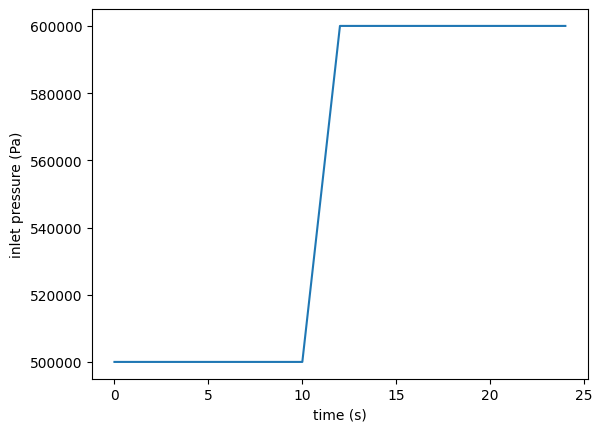

In [10]:
a = plt.plot(
    tj.time, tj.get_vec(m.fs.valve_1.control_volume.properties_in[24].pressure)
)
a = plt.ylabel("inlet pressure (Pa)")
a = plt.xlabel("time (s)")

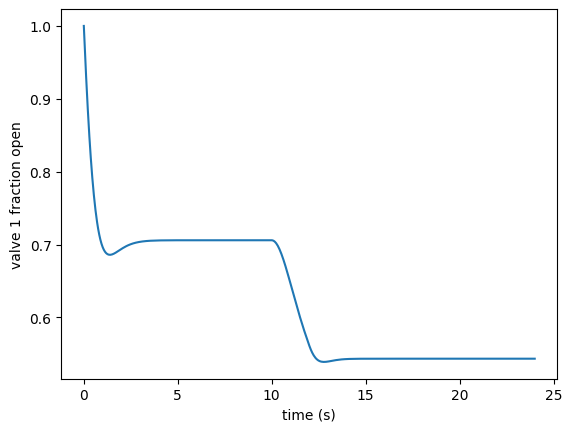

In [11]:
a = plt.plot(tj.time, tj.get_vec(m.fs.valve_1.valve_opening[24]))
a = plt.ylabel("valve 1 fraction open")
a = plt.xlabel("time (s)")

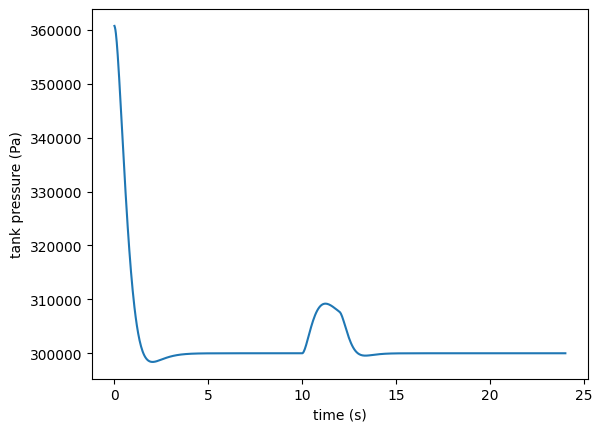

In [12]:
a = plt.plot(tj.time, tj.get_vec(m.fs.tank.control_volume.properties_out[24].pressure))
a = plt.ylabel("tank pressure (Pa)")
a = plt.xlabel("time (s)")

## Model a ramp in inlet pressure (again)

Here we repeat the ramp from the previous simulation in a different way.  In this case we do the integration in three parts. 1) Constant pressure at 500 kPa to 10 s 2) ramp from 500 to 600 kPa from 10 to 12 s. 3) Constant pressure at 600 kPa from 12 to 24 s.

In [13]:
# Create a new copy of the model that runs to 24 seconds, and add a constraint.

m = pid.create_model(
    time_set=[0, 10, 12, 24],
    nfe=3,
    calc_integ=True,
)
# time_var will be an explicit time variable we can use in constraints.
m.fs.time_var = pyo.Var(m.fs.time)

# We'll add a constraint to calculate the inlet pressure from 10 to 12s.  The rest of the
# time pressure will be fixed. For the time section from 10 to 12s, the constraints are
# defined by time 12; this means the pressure at time 12 should be unfixed and the
# pressure constraint should be active.  At all other times, pressure should be fixed and
# the pressure constraint should be deactivated.
m.fs.valve_1.control_volume.properties_in[0].pressure.fix(500000)
m.fs.valve_1.control_volume.properties_in[10].pressure.fix(500000)
m.fs.valve_1.control_volume.properties_in[12].pressure.set_value(600000)
m.fs.valve_1.control_volume.properties_in[12].pressure.unfix()
m.fs.valve_1.control_volume.properties_in[24].pressure.fix(600000)


@m.fs.Constraint(m.fs.time)
def inlet_pressure_eqn(b, t):
    return (
        b.valve_1.control_volume.properties_in[t].pressure
        == 50000 * (b.time_var[t] - 10) + 500000
    )


m.fs.inlet_pressure_eqn.deactivate()
m.fs.inlet_pressure_eqn[12].activate()

2023-11-02 10:31:48 [INFO] idaes.init.fs.valve_1: Initialization Complete: optimal - Optimal Solution Found


2023-11-02 10:31:48 [INFO] idaes.init.fs.tank.control_volume: Initialization Complete


2023-11-02 10:31:48 [INFO] idaes.init.fs.tank: Initialization Complete: optimal - Optimal Solution Found


2023-11-02 10:31:48 [INFO] idaes.init.fs.valve_2: Initialization Complete: optimal - Optimal Solution Found


In [14]:
# Solve the new problem.  Notice the argument specifying the explicit time variable.
result = petsc.petsc_dae_by_time_element(
    m,
    time=m.fs.time,
    timevar=m.fs.time_var,
    ts_options={
        "--ts_type": "beuler",
        "--ts_dt": 0.1,
        "--ts_monitor": "",  # set initial step to 0.1
        "--ts_save_trajectory": 1,
    },
)
tj = result.trajectory  # trajectroy data
res = result.results  # solver status list

2023-11-02 10:31:48 [INFO] idaes.solve.petsc-dae: Called fg_read, err: 0 (0 is good)


2023-11-02 10:31:48 [INFO] idaes.solve.petsc-dae: ---------------------------------------------------


2023-11-02 10:31:48 [INFO] idaes.solve.petsc-dae: DAE: 0


2023-11-02 10:31:48 [INFO] idaes.solve.petsc-dae: Reading nl file: C:\Users\dkgun\AppData\Local\Temp\tmp7g4th5iv.pyomo.nl


2023-11-02 10:31:48 [INFO] idaes.solve.petsc-dae: Number of constraints: 28


2023-11-02 10:31:48 [INFO] idaes.solve.petsc-dae: Number of nonlinear constraints: 14


2023-11-02 10:31:48 [INFO] idaes.solve.petsc-dae: Number of linear constraints: 14


2023-11-02 10:31:48 [INFO] idaes.solve.petsc-dae: Number of inequalities: 0


2023-11-02 10:31:48 [INFO] idaes.solve.petsc-dae: Number of variables: 28


2023-11-02 10:31:48 [INFO] idaes.solve.petsc-dae: Number of integers: 0


2023-11-02 10:31:48 [INFO] idaes.solve.petsc-dae: Number of binary: 0


2023-11-02 10:31:48 [INFO] idaes.solve.petsc-dae: Number of objectives: 0 (Ignoring)


2023-11-02 10:31:48 [INFO] idaes.solve.petsc-dae: Number of non-zeros in Jacobian: 83 


2023-11-02 10:31:48 [INFO] idaes.solve.petsc-dae: Number of degrees of freedom: 0


2023-11-02 10:31:48 [INFO] idaes.solve.petsc-dae: ---------------------------------------------------


2023-11-02 10:31:48 [INFO] idaes.solve.petsc-dae:   0 SNES Function norm 5.783088779321e+05 


2023-11-02 10:31:48 [INFO] idaes.solve.petsc-dae:   1 SNES Function norm 4.315325974705e+05 


2023-11-02 10:31:48 [INFO] idaes.solve.petsc-dae:   2 SNES Function norm 7.639793381288e+04 


2023-11-02 10:31:48 [INFO] idaes.solve.petsc-dae:   3 SNES Function norm 5.928557930246e+03 


2023-11-02 10:31:48 [INFO] idaes.solve.petsc-dae:   4 SNES Function norm 5.008361736228e+01 


2023-11-02 10:31:48 [INFO] idaes.solve.petsc-dae:   5 SNES Function norm 3.698195211732e-03 


2023-11-02 10:31:48 [INFO] idaes.solve.petsc-dae:   6 SNES Function norm 3.725294295263e-09 


2023-11-02 10:31:48 [INFO] idaes.solve.petsc-dae: SNESConvergedReason = SNES_CONVERGED_FNORM_RELATIVE, in 6 iterations


2023-11-02 10:31:48 [INFO] idaes.solve.petsc-dae: SNES_CONVERGED_FNORM_RELATIVE


2023-11-02 10:31:48 [INFO] idaes.solve.petsc-dae: WARNING: model contains export suffix 'dae_suffix' that contains 1 component


2023-11-02 10:31:48 [INFO] idaes.solve.petsc-dae: keys that are not exported as part of the NL file.  Skipping.


2023-11-02 10:31:48 [INFO] idaes.solve.petsc-dae: Called fg_read, err: 0 (0 is good)


2023-11-02 10:31:48 [INFO] idaes.solve.petsc-dae: ---------------------------------------------------


2023-11-02 10:31:48 [INFO] idaes.solve.petsc-dae: DAE: 1


2023-11-02 10:31:48 [INFO] idaes.solve.petsc-dae: Reading nl file: C:\Users\dkgun\AppData\Local\Temp\tmprvabt9ma.pyomo.nl


2023-11-02 10:31:48 [INFO] idaes.solve.petsc-dae: Number of constraints: 29


2023-11-02 10:31:48 [INFO] idaes.solve.petsc-dae: Number of nonlinear constraints: 15


2023-11-02 10:31:48 [INFO] idaes.solve.petsc-dae: Number of linear constraints: 14


2023-11-02 10:31:48 [INFO] idaes.solve.petsc-dae: Number of inequalities: 0


2023-11-02 10:31:48 [INFO] idaes.solve.petsc-dae: Number of variables: 34


2023-11-02 10:31:48 [INFO] idaes.solve.petsc-dae: Number of integers: 0


2023-11-02 10:31:48 [INFO] idaes.solve.petsc-dae: Number of binary: 0


2023-11-02 10:31:48 [INFO] idaes.solve.petsc-dae: Number of objectives: 0 (Ignoring)


2023-11-02 10:31:48 [INFO] idaes.solve.petsc-dae: Number of non-zeros in Jacobian: 91 


2023-11-02 10:31:48 [INFO] idaes.solve.petsc-dae: Explicit time variable: 0


2023-11-02 10:31:49 [INFO] idaes.solve.petsc-dae: Number of derivatives: 5


2023-11-02 10:31:49 [INFO] idaes.solve.petsc-dae: Number of differential vars: 5


2023-11-02 10:31:49 [INFO] idaes.solve.petsc-dae: Number of algebraic vars: 24


2023-11-02 10:31:49 [INFO] idaes.solve.petsc-dae: Number of state vars: 29


2023-11-02 10:31:49 [INFO] idaes.solve.petsc-dae: Number of degrees of freedom: 0


2023-11-02 10:31:49 [INFO] idaes.solve.petsc-dae: ---------------------------------------------------


2023-11-02 10:31:49 [INFO] idaes.solve.petsc-dae: 0 TS dt 0.1 time 0.


2023-11-02 10:31:52 [INFO] idaes.solve.petsc-dae: 1 TS dt 0.025 time 0.025


2023-11-02 10:31:52 [INFO] idaes.solve.petsc-dae: 2 TS dt 0.0154252 time 0.0381739


2023-11-02 10:31:52 [INFO] idaes.solve.petsc-dae: 3 TS dt 0.0133373 time 0.0510085


2023-11-02 10:31:52 [INFO] idaes.solve.petsc-dae: 4 TS dt 0.0136013 time 0.0643458


2023-11-02 10:31:52 [INFO] idaes.solve.petsc-dae: 5 TS dt 0.0141735 time 0.0779471


2023-11-02 10:31:52 [INFO] idaes.solve.petsc-dae: 6 TS dt 0.0146392 time 0.0921205


2023-11-02 10:31:52 [INFO] idaes.solve.petsc-dae: 7 TS dt 0.0152517 time 0.10676


2023-11-02 10:31:52 [INFO] idaes.solve.petsc-dae: 8 TS dt 0.0158389 time 0.122011


2023-11-02 10:31:52 [INFO] idaes.solve.petsc-dae: 9 TS dt 0.0165162 time 0.13785


2023-11-02 10:31:52 [INFO] idaes.solve.petsc-dae: 10 TS dt 0.0172093 time 0.154367


2023-11-02 10:31:52 [INFO] idaes.solve.petsc-dae: 11 TS dt 0.0179712 time 0.171576


2023-11-02 10:31:52 [INFO] idaes.solve.petsc-dae: 12 TS dt 0.0187679 time 0.189547


2023-11-02 10:31:52 [INFO] idaes.solve.petsc-dae: 13 TS dt 0.0196222 time 0.208315


2023-11-02 10:31:52 [INFO] idaes.solve.petsc-dae: 14 TS dt 0.020514 time 0.227937


2023-11-02 10:31:52 [INFO] idaes.solve.petsc-dae: 15 TS dt 0.0214472 time 0.248451


2023-11-02 10:31:52 [INFO] idaes.solve.petsc-dae: 16 TS dt 0.022401 time 0.269898


2023-11-02 10:31:52 [INFO] idaes.solve.petsc-dae: 17 TS dt 0.0233619 time 0.292299


2023-11-02 10:31:52 [INFO] idaes.solve.petsc-dae: 18 TS dt 0.0243005 time 0.315661


2023-11-02 10:31:52 [INFO] idaes.solve.petsc-dae: 19 TS dt 0.0251894 time 0.339962


2023-11-02 10:31:53 [INFO] idaes.solve.petsc-dae: 20 TS dt 0.0259944 time 0.365151


2023-11-02 10:31:53 [INFO] idaes.solve.petsc-dae: 21 TS dt 0.0266898 time 0.391146


2023-11-02 10:31:53 [INFO] idaes.solve.petsc-dae: 22 TS dt 0.0272563 time 0.417835


2023-11-02 10:31:53 [INFO] idaes.solve.petsc-dae: 23 TS dt 0.0276902 time 0.445092


2023-11-02 10:31:53 [INFO] idaes.solve.petsc-dae: 24 TS dt 0.0279997 time 0.472782


2023-11-02 10:31:53 [INFO] idaes.solve.petsc-dae: 25 TS dt 0.0282038 time 0.500782


2023-11-02 10:31:53 [INFO] idaes.solve.petsc-dae: 26 TS dt 0.028326 time 0.528985


2023-11-02 10:31:53 [INFO] idaes.solve.petsc-dae: 27 TS dt 0.0283913 time 0.557311


2023-11-02 10:31:53 [INFO] idaes.solve.petsc-dae: 28 TS dt 0.0284218 time 0.585703


2023-11-02 10:31:53 [INFO] idaes.solve.petsc-dae: 29 TS dt 0.0284362 time 0.614124


2023-11-02 10:31:53 [INFO] idaes.solve.petsc-dae: 30 TS dt 0.0284488 time 0.642561


2023-11-02 10:31:53 [INFO] idaes.solve.petsc-dae: 31 TS dt 0.0284703 time 0.671009


2023-11-02 10:31:53 [INFO] idaes.solve.petsc-dae: 32 TS dt 0.0285087 time 0.69948


2023-11-02 10:31:53 [INFO] idaes.solve.petsc-dae: 33 TS dt 0.0285693 time 0.727988


2023-11-02 10:31:53 [INFO] idaes.solve.petsc-dae: 34 TS dt 0.0286562 time 0.756558


2023-11-02 10:31:53 [INFO] idaes.solve.petsc-dae: 35 TS dt 0.0287722 time 0.785214


2023-11-02 10:31:53 [INFO] idaes.solve.petsc-dae: 36 TS dt 0.0289195 time 0.813986


2023-11-02 10:31:53 [INFO] idaes.solve.petsc-dae: 37 TS dt 0.0291001 time 0.842906


2023-11-02 10:31:53 [INFO] idaes.solve.petsc-dae: 38 TS dt 0.0293154 time 0.872006


2023-11-02 10:31:53 [INFO] idaes.solve.petsc-dae: 39 TS dt 0.0295672 time 0.901321


2023-11-02 10:31:53 [INFO] idaes.solve.petsc-dae: 40 TS dt 0.0298571 time 0.930888


2023-11-02 10:31:53 [INFO] idaes.solve.petsc-dae: 41 TS dt 0.0301872 time 0.960745


2023-11-02 10:31:53 [INFO] idaes.solve.petsc-dae: 42 TS dt 0.0305596 time 0.990933


2023-11-02 10:31:53 [INFO] idaes.solve.petsc-dae: 43 TS dt 0.0309769 time 1.02149


2023-11-02 10:31:53 [INFO] idaes.solve.petsc-dae: 44 TS dt 0.031442 time 1.05247


2023-11-02 10:31:53 [INFO] idaes.solve.petsc-dae: 45 TS dt 0.0319585 time 1.08391


2023-11-02 10:31:53 [INFO] idaes.solve.petsc-dae: 46 TS dt 0.0325305 time 1.11587


2023-11-02 10:31:53 [INFO] idaes.solve.petsc-dae: 47 TS dt 0.0331626 time 1.1484


2023-11-02 10:31:53 [INFO] idaes.solve.petsc-dae: 48 TS dt 0.0338606 time 1.18156


2023-11-02 10:31:53 [INFO] idaes.solve.petsc-dae: 49 TS dt 0.0346311 time 1.21542


2023-11-02 10:31:53 [INFO] idaes.solve.petsc-dae: 50 TS dt 0.0354817 time 1.25005


2023-11-02 10:31:53 [INFO] idaes.solve.petsc-dae: 51 TS dt 0.0364218 time 1.28554


2023-11-02 10:31:53 [INFO] idaes.solve.petsc-dae: 52 TS dt 0.0374622 time 1.32196


2023-11-02 10:31:53 [INFO] idaes.solve.petsc-dae: 53 TS dt 0.0386159 time 1.35942


2023-11-02 10:31:54 [INFO] idaes.solve.petsc-dae: 54 TS dt 0.0398987 time 1.39804


2023-11-02 10:31:54 [INFO] idaes.solve.petsc-dae: 55 TS dt 0.0413295 time 1.43793


2023-11-02 10:31:54 [INFO] idaes.solve.petsc-dae: 56 TS dt 0.0429313 time 1.47926


2023-11-02 10:31:54 [INFO] idaes.solve.petsc-dae: 57 TS dt 0.0447325 time 1.5222


2023-11-02 10:31:54 [INFO] idaes.solve.petsc-dae: 58 TS dt 0.0467682 time 1.56693


2023-11-02 10:31:54 [INFO] idaes.solve.petsc-dae: 59 TS dt 0.0490823 time 1.6137


2023-11-02 10:31:54 [INFO] idaes.solve.petsc-dae: 60 TS dt 0.0517305 time 1.66278


2023-11-02 10:31:54 [INFO] idaes.solve.petsc-dae: 61 TS dt 0.0547839 time 1.71451


2023-11-02 10:31:54 [INFO] idaes.solve.petsc-dae: 62 TS dt 0.0583343 time 1.76929


2023-11-02 10:31:54 [INFO] idaes.solve.petsc-dae: 63 TS dt 0.0625012 time 1.82763


2023-11-02 10:31:54 [INFO] idaes.solve.petsc-dae: 64 TS dt 0.0674415 time 1.89013


2023-11-02 10:31:54 [INFO] idaes.solve.petsc-dae: 65 TS dt 0.0733598 time 1.95757


2023-11-02 10:31:54 [INFO] idaes.solve.petsc-dae: 66 TS dt 0.0805186 time 2.03093


2023-11-02 10:31:54 [INFO] idaes.solve.petsc-dae: 67 TS dt 0.0892348 time 2.11145


2023-11-02 10:31:54 [INFO] idaes.solve.petsc-dae: 68 TS dt 0.0998324 time 2.20068


2023-11-02 10:31:54 [INFO] idaes.solve.petsc-dae: 69 TS dt 0.112487 time 2.30052


2023-11-02 10:31:54 [INFO] idaes.solve.petsc-dae: 70 TS dt 0.12691 time 2.413


2023-11-02 10:31:54 [INFO] idaes.solve.petsc-dae: 71 TS dt 0.142117 time 2.53991


2023-11-02 10:31:54 [INFO] idaes.solve.petsc-dae: 72 TS dt 0.157007 time 2.68203


2023-11-02 10:31:54 [INFO] idaes.solve.petsc-dae: 73 TS dt 0.171623 time 2.83904


2023-11-02 10:31:54 [INFO] idaes.solve.petsc-dae: 74 TS dt 0.187368 time 3.01066


2023-11-02 10:31:54 [INFO] idaes.solve.petsc-dae: 75 TS dt 0.206382 time 3.19803


2023-11-02 10:31:54 [INFO] idaes.solve.petsc-dae: 76 TS dt 0.231364 time 3.40441


2023-11-02 10:31:54 [INFO] idaes.solve.petsc-dae: 77 TS dt 0.266076 time 3.63577


2023-11-02 10:31:54 [INFO] idaes.solve.petsc-dae: 78 TS dt 0.316702 time 3.90185


2023-11-02 10:31:54 [INFO] idaes.solve.petsc-dae: 79 TS dt 0.394852 time 4.21855


2023-11-02 10:31:54 [INFO] idaes.solve.petsc-dae: 80 TS dt 0.525171 time 4.6134


2023-11-02 10:31:54 [INFO] idaes.solve.petsc-dae: 81 TS dt 0.767756 time 5.13857


2023-11-02 10:31:54 [INFO] idaes.solve.petsc-dae: 82 TS dt 1.29836 time 5.90633


2023-11-02 10:31:54 [INFO] idaes.solve.petsc-dae: 83 TS dt 2.79531 time 7.20469


2023-11-02 10:31:54 [INFO] idaes.solve.petsc-dae: 84 TS dt 8.85294 time 10.


2023-11-02 10:31:54 [INFO] idaes.solve.petsc-dae: TSConvergedReason = TS_CONVERGED_TIME


2023-11-02 10:31:54 [INFO] idaes.solve.petsc-dae: TS_CONVERGED_TIME


2023-11-02 10:31:55 [INFO] idaes.solve.petsc-dae: Called fg_read, err: 0 (0 is good)


2023-11-02 10:31:55 [INFO] idaes.solve.petsc-dae: ---------------------------------------------------


2023-11-02 10:31:55 [INFO] idaes.solve.petsc-dae: DAE: 1


2023-11-02 10:31:55 [INFO] idaes.solve.petsc-dae: Reading nl file: C:\Users\dkgun\AppData\Local\Temp\tmp4d4exz1y.pyomo.nl


2023-11-02 10:31:55 [INFO] idaes.solve.petsc-dae: Number of constraints: 30


2023-11-02 10:31:55 [INFO] idaes.solve.petsc-dae: Number of nonlinear constraints: 16


2023-11-02 10:31:55 [INFO] idaes.solve.petsc-dae: Number of linear constraints: 14


2023-11-02 10:31:55 [INFO] idaes.solve.petsc-dae: Number of inequalities: 0


2023-11-02 10:31:55 [INFO] idaes.solve.petsc-dae: Number of variables: 36


2023-11-02 10:31:55 [INFO] idaes.solve.petsc-dae: Number of integers: 0


2023-11-02 10:31:55 [INFO] idaes.solve.petsc-dae: Number of binary: 0


2023-11-02 10:31:55 [INFO] idaes.solve.petsc-dae: Number of objectives: 0 (Ignoring)


2023-11-02 10:31:55 [INFO] idaes.solve.petsc-dae: Number of non-zeros in Jacobian: 98 


2023-11-02 10:31:55 [INFO] idaes.solve.petsc-dae: Explicit time variable: 1


2023-11-02 10:31:55 [INFO] idaes.solve.petsc-dae: Number of derivatives: 5


2023-11-02 10:31:55 [INFO] idaes.solve.petsc-dae: Number of differential vars: 5


2023-11-02 10:31:55 [INFO] idaes.solve.petsc-dae: Number of algebraic vars: 25


2023-11-02 10:31:55 [INFO] idaes.solve.petsc-dae: Number of state vars: 30


2023-11-02 10:31:55 [INFO] idaes.solve.petsc-dae: Number of degrees of freedom: 0


2023-11-02 10:31:55 [INFO] idaes.solve.petsc-dae: ---------------------------------------------------


2023-11-02 10:31:55 [INFO] idaes.solve.petsc-dae: 0 TS dt 0.1 time 10.


2023-11-02 10:31:55 [INFO] idaes.solve.petsc-dae: 1 TS dt 0.1 time 10.1


2023-11-02 10:31:55 [INFO] idaes.solve.petsc-dae: 2 TS dt 0.0448184 time 10.1371


2023-11-02 10:31:55 [INFO] idaes.solve.petsc-dae: 3 TS dt 0.0362261 time 10.1719


2023-11-02 10:31:55 [INFO] idaes.solve.petsc-dae: 4 TS dt 0.037926 time 10.2081


2023-11-02 10:31:55 [INFO] idaes.solve.petsc-dae: 5 TS dt 0.040655 time 10.246


2023-11-02 10:31:55 [INFO] idaes.solve.petsc-dae: 6 TS dt 0.0432601 time 10.2867


2023-11-02 10:31:55 [INFO] idaes.solve.petsc-dae: 7 TS dt 0.0460301 time 10.3299


2023-11-02 10:31:55 [INFO] idaes.solve.petsc-dae: 8 TS dt 0.0483791 time 10.376


2023-11-02 10:31:55 [INFO] idaes.solve.petsc-dae: 9 TS dt 0.0503537 time 10.4243


2023-11-02 10:31:55 [INFO] idaes.solve.petsc-dae: 10 TS dt 0.0518023 time 10.4747


2023-11-02 10:31:55 [INFO] idaes.solve.petsc-dae: 11 TS dt 0.0529149 time 10.5265


2023-11-02 10:31:55 [INFO] idaes.solve.petsc-dae: 12 TS dt 0.0538116 time 10.5794


2023-11-02 10:31:55 [INFO] idaes.solve.petsc-dae: 13 TS dt 0.0546803 time 10.6332


2023-11-02 10:31:55 [INFO] idaes.solve.petsc-dae: 14 TS dt 0.0556299 time 10.6879


2023-11-02 10:31:55 [INFO] idaes.solve.petsc-dae: 15 TS dt 0.056762 time 10.7435


2023-11-02 10:31:55 [INFO] idaes.solve.petsc-dae: 16 TS dt 0.0581408 time 10.8003


2023-11-02 10:31:55 [INFO] idaes.solve.petsc-dae: 17 TS dt 0.0598299 time 10.8584


2023-11-02 10:31:55 [INFO] idaes.solve.petsc-dae: 18 TS dt 0.0618893 time 10.9183


2023-11-02 10:31:55 [INFO] idaes.solve.petsc-dae: 19 TS dt 0.0643931 time 10.9802


2023-11-02 10:31:56 [INFO] idaes.solve.petsc-dae: 20 TS dt 0.0674341 time 11.0445


2023-11-02 10:31:56 [INFO] idaes.solve.petsc-dae: 21 TS dt 0.0711384 time 11.112


2023-11-02 10:31:56 [INFO] idaes.solve.petsc-dae: 22 TS dt 0.0756776 time 11.1831


2023-11-02 10:31:56 [INFO] idaes.solve.petsc-dae: 23 TS dt 0.0812903 time 11.2588


2023-11-02 10:31:56 [INFO] idaes.solve.petsc-dae: 24 TS dt 0.0883011 time 11.3401


2023-11-02 10:31:56 [INFO] idaes.solve.petsc-dae: 25 TS dt 0.09713 time 11.4284


2023-11-02 10:31:56 [INFO] idaes.solve.petsc-dae: 26 TS dt 0.108211 time 11.5255


2023-11-02 10:31:56 [INFO] idaes.solve.petsc-dae: 27 TS dt 0.121606 time 11.6337


2023-11-02 10:31:56 [INFO] idaes.solve.petsc-dae: 28 TS dt 0.122333 time 11.7553


2023-11-02 10:31:56 [INFO] idaes.solve.petsc-dae: 29 TS dt 0.122333 time 11.8777


2023-11-02 10:31:56 [INFO] idaes.solve.petsc-dae: 30 TS dt 0.159258 time 12.


2023-11-02 10:31:56 [INFO] idaes.solve.petsc-dae: TSConvergedReason = TS_CONVERGED_TIME


2023-11-02 10:31:56 [INFO] idaes.solve.petsc-dae: TS_CONVERGED_TIME


2023-11-02 10:31:56 [INFO] idaes.solve.petsc-dae: WARNING: model contains export suffix 'dae_suffix' that contains 1 component


2023-11-02 10:31:56 [INFO] idaes.solve.petsc-dae: keys that are not exported as part of the NL file.  Skipping.


2023-11-02 10:31:56 [INFO] idaes.solve.petsc-dae: Called fg_read, err: 0 (0 is good)


2023-11-02 10:31:56 [INFO] idaes.solve.petsc-dae: ---------------------------------------------------


2023-11-02 10:31:56 [INFO] idaes.solve.petsc-dae: DAE: 1


2023-11-02 10:31:56 [INFO] idaes.solve.petsc-dae: Reading nl file: C:\Users\dkgun\AppData\Local\Temp\tmp1qggvz23.pyomo.nl


2023-11-02 10:31:56 [INFO] idaes.solve.petsc-dae: Number of constraints: 29


2023-11-02 10:31:56 [INFO] idaes.solve.petsc-dae: Number of nonlinear constraints: 15


2023-11-02 10:31:56 [INFO] idaes.solve.petsc-dae: Number of linear constraints: 14


2023-11-02 10:31:56 [INFO] idaes.solve.petsc-dae: Number of inequalities: 0


2023-11-02 10:31:56 [INFO] idaes.solve.petsc-dae: Number of variables: 34


2023-11-02 10:31:56 [INFO] idaes.solve.petsc-dae: Number of integers: 0


2023-11-02 10:31:56 [INFO] idaes.solve.petsc-dae: Number of binary: 0


2023-11-02 10:31:56 [INFO] idaes.solve.petsc-dae: Number of objectives: 0 (Ignoring)


2023-11-02 10:31:56 [INFO] idaes.solve.petsc-dae: Number of non-zeros in Jacobian: 91 


2023-11-02 10:31:56 [INFO] idaes.solve.petsc-dae: Explicit time variable: 0


2023-11-02 10:31:56 [INFO] idaes.solve.petsc-dae: Number of derivatives: 5


2023-11-02 10:31:56 [INFO] idaes.solve.petsc-dae: Number of differential vars: 5


2023-11-02 10:31:56 [INFO] idaes.solve.petsc-dae: Number of algebraic vars: 24


2023-11-02 10:31:56 [INFO] idaes.solve.petsc-dae: Number of state vars: 29


2023-11-02 10:31:56 [INFO] idaes.solve.petsc-dae: Number of degrees of freedom: 0


2023-11-02 10:31:56 [INFO] idaes.solve.petsc-dae: ---------------------------------------------------


2023-11-02 10:31:56 [INFO] idaes.solve.petsc-dae: 0 TS dt 0.1 time 12.


2023-11-02 10:31:56 [INFO] idaes.solve.petsc-dae: 1 TS dt 0.1 time 12.1


2023-11-02 10:31:56 [INFO] idaes.solve.petsc-dae: 2 TS dt 0.0494004 time 12.1411


2023-11-02 10:31:57 [INFO] idaes.solve.petsc-dae: 3 TS dt 0.0407055 time 12.1802


2023-11-02 10:31:57 [INFO] idaes.solve.petsc-dae: 4 TS dt 0.0422725 time 12.2209


2023-11-02 10:31:57 [INFO] idaes.solve.petsc-dae: 5 TS dt 0.0447524 time 12.2632


2023-11-02 10:31:57 [INFO] idaes.solve.petsc-dae: 6 TS dt 0.0468318 time 12.3079


2023-11-02 10:31:57 [INFO] idaes.solve.petsc-dae: 7 TS dt 0.0490217 time 12.3548


2023-11-02 10:31:57 [INFO] idaes.solve.petsc-dae: 8 TS dt 0.0508279 time 12.4038


2023-11-02 10:31:57 [INFO] idaes.solve.petsc-dae: 9 TS dt 0.0525655 time 12.4546


2023-11-02 10:31:57 [INFO] idaes.solve.petsc-dae: 10 TS dt 0.0541373 time 12.5072


2023-11-02 10:31:57 [INFO] idaes.solve.petsc-dae: 11 TS dt 0.055779 time 12.5613


2023-11-02 10:31:57 [INFO] idaes.solve.petsc-dae: 12 TS dt 0.057531 time 12.6171


2023-11-02 10:31:57 [INFO] idaes.solve.petsc-dae: 13 TS dt 0.0595583 time 12.6746


2023-11-02 10:31:57 [INFO] idaes.solve.petsc-dae: 14 TS dt 0.061941 time 12.7342


2023-11-02 10:31:57 [INFO] idaes.solve.petsc-dae: 15 TS dt 0.064821 time 12.7961


2023-11-02 10:31:57 [INFO] idaes.solve.petsc-dae: 16 TS dt 0.0683275 time 12.8609


2023-11-02 10:31:57 [INFO] idaes.solve.petsc-dae: 17 TS dt 0.0726534 time 12.9293


2023-11-02 10:31:57 [INFO] idaes.solve.petsc-dae: 18 TS dt 0.0780452 time 13.0019


2023-11-02 10:31:57 [INFO] idaes.solve.petsc-dae: 19 TS dt 0.0848677 time 13.08


2023-11-02 10:31:57 [INFO] idaes.solve.petsc-dae: 20 TS dt 0.093653 time 13.1648


2023-11-02 10:31:57 [INFO] idaes.solve.petsc-dae: 21 TS dt 0.105212 time 13.2585


2023-11-02 10:31:57 [INFO] idaes.solve.petsc-dae: 22 TS dt 0.120767 time 13.3637


2023-11-02 10:31:57 [INFO] idaes.solve.petsc-dae: 23 TS dt 0.142036 time 13.4845


2023-11-02 10:31:57 [INFO] idaes.solve.petsc-dae: 24 TS dt 0.170717 time 13.6265


2023-11-02 10:31:57 [INFO] idaes.solve.petsc-dae: 25 TS dt 0.206234 time 13.7972


2023-11-02 10:31:57 [INFO] idaes.solve.petsc-dae: 26 TS dt 0.244736 time 14.0034


2023-11-02 10:31:57 [INFO] idaes.solve.petsc-dae: 27 TS dt 0.288411 time 14.2482


2023-11-02 10:31:57 [INFO] idaes.solve.petsc-dae: 28 TS dt 0.350093 time 14.5366


2023-11-02 10:31:57 [INFO] idaes.solve.petsc-dae: 29 TS dt 0.453668 time 14.8867


2023-11-02 10:31:57 [INFO] idaes.solve.petsc-dae: 30 TS dt 0.655245 time 15.3404


2023-11-02 10:31:57 [INFO] idaes.solve.petsc-dae: 31 TS dt 1.1261 time 15.9956


2023-11-02 10:31:57 [INFO] idaes.solve.petsc-dae: 32 TS dt 2.56902 time 17.1217


2023-11-02 10:31:57 [INFO] idaes.solve.petsc-dae: 33 TS dt 4.30929 time 19.6907


2023-11-02 10:31:57 [INFO] idaes.solve.petsc-dae: 34 TS dt 26.3639 time 24.


2023-11-02 10:31:57 [INFO] idaes.solve.petsc-dae: TSConvergedReason = TS_CONVERGED_TIME


2023-11-02 10:31:57 [INFO] idaes.solve.petsc-dae: TS_CONVERGED_TIME


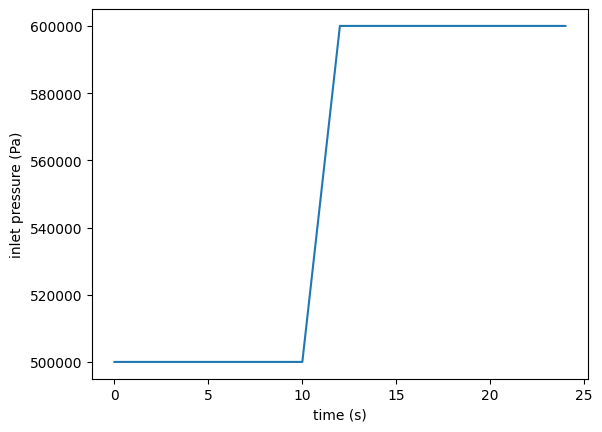

In [15]:
a = plt.plot(
    tj.time, tj.get_vec(m.fs.valve_1.control_volume.properties_in[24].pressure)
)
a = plt.ylabel("inlet pressure (Pa)")
a = plt.xlabel("time (s)")

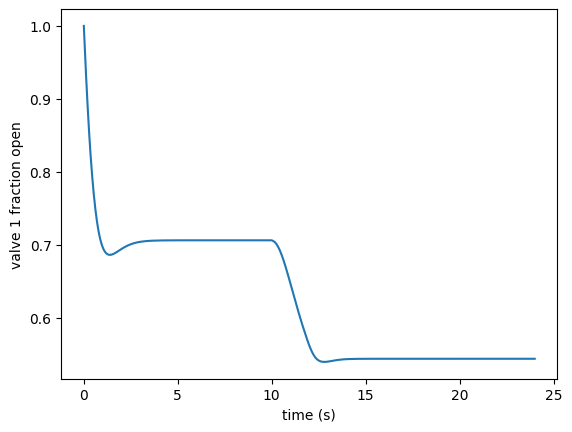

In [16]:
a = plt.plot(tj.time, tj.get_vec(m.fs.valve_1.valve_opening[24]))
a = plt.ylabel("valve 1 fraction open")
a = plt.xlabel("time (s)")

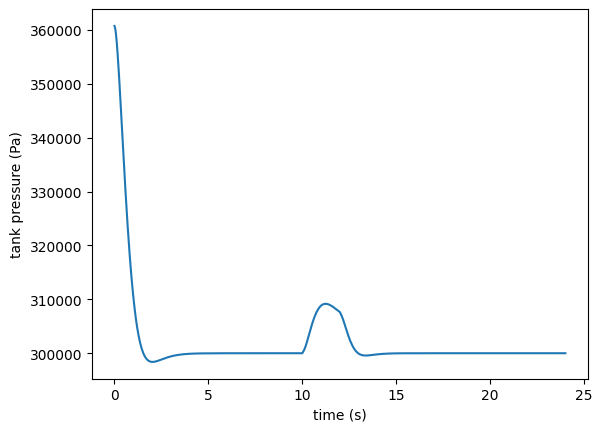

In [17]:
a = plt.plot(tj.time, tj.get_vec(m.fs.tank.control_volume.properties_out[24].pressure))
a = plt.ylabel("tank pressure (Pa)")
a = plt.xlabel("time (s)")